In [20]:
import os
import json
import zipfile
import subprocess
import shutil
import getpass
import math
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image,ImageReadMode
from pytorch_metric_learning import losses, regularizers
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(20)

In [3]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

Using cpu device


In [4]:
dataset_save_dir = './dataset'

In [8]:
def one_hot_encode(val):
    arr = numpy.zeros((6,), dtype=int)
    arr[val] = 1
    return arr

def get_bucket_id(age):
  age_floor = int(age)
  if age_floor >= 0 and age_floor <= 5: return 0
  elif age_floor >= 6 and age_floor <= 12: return 1
  elif age_floor >= 13 and age_floor <= 19: return 2
  elif age_floor >= 20 and age_floor <= 29: return 3
  elif age_floor >= 30 and age_floor <= 59: return 4
  else: return 5

def get_ground_truth(age):
  return one_hot_encode(get_bucket_id(age))

In [9]:
class XRayToothDataset(Dataset):
    def __init__(self, cwd, img_dir, transform=None, target_height=None, target_width=None):
        self.dataset_path = cwd + '/' + img_dir
        self.transform = transform
        self.target_height = target_height
        self.target_width = target_width

    def __len__(self):
        return len(os.listdir(self.dataset_path))

    def __getitem__(self, idx):
        if idx  >= len(os.listdir(self.dataset_path)):
            print("No datafile/image at index : "+ str(idx))
            return None
        img_filename = os.listdir(self.dataset_path)[idx]
        age = float(img_filename.split("_")[1][:-4])
        age_gt = get_ground_truth(age)
        image_tensor = read_image(path=self.dataset_path + '/' + img_filename)
        image_tensor = image_tensor.reshape(1, 3, image_tensor.shape[-2], image_tensor.shape[-1])
        if self.target_height and self.target_width: # Resize the image 
            image_tensor = torch.nn.functional.interpolate(image_tensor, (self.target_height,self.target_width))
        if self.transform: image_tensor = self.transform(image_tensor) # Apply transformations
        image_tensor = (image_tensor-image_tensor.min())/(image_tensor.max()-image_tensor.min())
        return image_tensor.reshape(-1,image_tensor.shape[-2],image_tensor.shape[-1]).to(torch.float32), torch.tensor(age_gt)

In [11]:
training_data = XRayToothDataset(os.getcwd(), img_dir=dataset_save_dir+'/training', transform=None, target_height=224, target_width=224)
validation_data = XRayToothDataset(os.getcwd(), img_dir=dataset_save_dir+'/validation', transform=None, target_height=224, target_width=224)

In [12]:
from torchvision.models import vit_l_32, ViT_L_32_Weights

pretrained_vit = vit_l_32(weights=ViT_L_32_Weights.IMAGENET1K_V1)

In [13]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

pretrained_effnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone1 = pretrained_vit
        self.backbone2 = pretrained_effnet

        for param in self.backbone1.parameters():
            param.requires_grad = False

        for param in self.backbone2.parameters():
            param.requires_grad = False

        self.fc = nn.Sequential(
            nn.Dropout(0.6),
            nn.Linear(2000,512),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(512,256),
        )

        self.margin_loss_regularizer = regularizers.RegularFaceRegularizer()
        self.margin_loss_function = losses.ArcFaceLoss(6, 256, margin=34.3, scale=1, weight_regularizer=self.margin_loss_regularizer)

    def forward(self, x):
        x1 = self.backbone1(x)
        x2 = self.backbone2(x)
        x = torch.cat((x1,x2), 1)
        x = self.fc(x)
        return x

In [22]:
model = NeuralNetwork().to(device)

In [23]:
model.load_state_dict(torch.load('./best_model@68.99%.pth')['model_state_dict'])
model.eval()

NeuralNetwork(
  (backbone1): VisionTransformer(
    (conv_proj): Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=1024, out_features=4096, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=4096, out_features=1024, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
        

# Running GradCAM for model interpretability

In [20]:
!pip install grad-cam

In [21]:
# Load the GradCAM required libraries
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, LayerCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image 
from pytorch_grad_cam.ablation_layer import AblationLayerVit

In [22]:
# Turn on the gradients for GradCAM
for param in model.backbone1.parameters():
    param.requires_grad = True

for param in model.backbone2.parameters():
    param.requires_grad = True

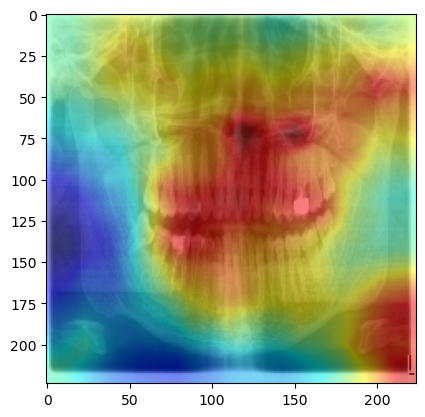

In [23]:
# Select the layers in model to find activation
target_layers = [model.fc[-1]]

# Prepare the GradCAM on the model's specific layers
cam = FullGrad(model=model, target_layers=target_layers, use_cuda=False)

# Preprare a sample image to run the GradCAM
selected_image = training_data[0]
input_tensor = selected_image[0].unsqueeze(dim=0)
input_class = selected_image[1].argmax().item()
targets = [ClassifierOutputTarget(input_class)]

# Get the CAM's for the input tensor
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]

# Visualize
visualization = show_cam_on_image(input_tensor[0].permute(1, 2, 0).numpy(), grayscale_cam, use_rgb=True)
plt.imshow(visualization)

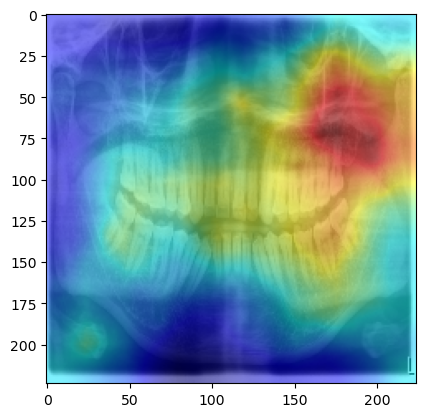

In [28]:
# Select the layers in model to find activation
target_layers = [model.fc[-1]]
#target_layers = [model.backbone2.features[-1][0]]

# def reshape_transform(tensor, height=16, width=16):
#     result = tensor[:, 1 :  , :].reshape(tensor.size(0),
#         height, width, tensor.size(2))

#     # Bring the channels to the first dimension,
#     # like in CNNs.
#     result = result.transpose(2, 3).transpose(1, 2)
#     return result

# Prepare the GradCAM on the model's specific layers
cam = FullGrad(model=model, target_layers=target_layers, use_cuda=False)

# Preprare a sample image to run the GradCAM
selected_image = training_data[1]
input_tensor = selected_image[0].unsqueeze(dim=0)
input_class = selected_image[1].argmax().item()
targets = [ClassifierOutputTarget(input_class)]

# Get the CAM's for the input tensor
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]

# Visualize
visualization = show_cam_on_image(input_tensor[0].permute(1, 2, 0).numpy(), grayscale_cam, use_rgb=True)
plt.imshow(visualization)

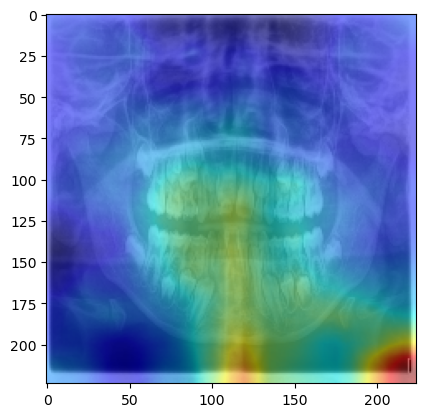

In [27]:
# Select the layers in model to find activation
target_layers = [model.fc[-1]]
#target_layers = [model.backbone2.features[-1][0]]

# def reshape_transform(tensor, height=16, width=16):
#     result = tensor[:, 1 :  , :].reshape(tensor.size(0),
#         height, width, tensor.size(2))

#     # Bring the channels to the first dimension,
#     # like in CNNs.
#     result = result.transpose(2, 3).transpose(1, 2)
#     return result

# Prepare the GradCAM on the model's specific layers
cam = FullGrad(model=model, target_layers=target_layers, use_cuda=False)

# Preprare a sample image to run the GradCAM
selected_image = training_data[2]
input_tensor = selected_image[0].unsqueeze(dim=0)
input_class = selected_image[1].argmax().item()
targets = [ClassifierOutputTarget(input_class)]

# Get the CAM's for the input tensor
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]

# Visualize
visualization = show_cam_on_image(input_tensor[0].permute(1, 2, 0).numpy(), grayscale_cam, use_rgb=True)
plt.imshow(visualization)

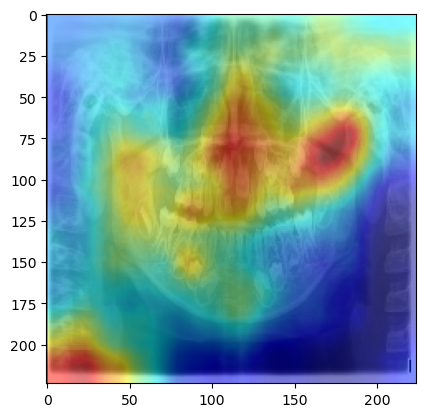

In [24]:
# Select the layers in model to find activation
target_layers = [model.fc[-1]]
#target_layers = [model.backbone2.features[-1][0]]

# def reshape_transform(tensor, height=16, width=16):
#     result = tensor[:, 1 :  , :].reshape(tensor.size(0),
#         height, width, tensor.size(2))

#     # Bring the channels to the first dimension,
#     # like in CNNs.
#     result = result.transpose(2, 3).transpose(1, 2)
#     return result

# Prepare the GradCAM on the model's specific layers
cam = FullGrad(model=model, target_layers=target_layers, use_cuda=False)

# Preprare a sample image to run the GradCAM
selected_image = training_data[3]
input_tensor = selected_image[0].unsqueeze(dim=0)
input_class = selected_image[1].argmax().item()
targets = [ClassifierOutputTarget(input_class)]

# Get the CAM's for the input tensor
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]

# Visualize
visualization = show_cam_on_image(input_tensor[0].permute(1, 2, 0).numpy(), grayscale_cam, use_rgb=True)
plt.imshow(visualization)